# Задание 2
## Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

## Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [64]:
# Импортируем необходимые библиотеки
import seaborn as sns
import pandas as pd
import requests
import urllib
import json
from scipy.stats import norm
import scipy.stats as st
from decimal import Decimal
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  
pd.set_option('display.max_rows', 24)
pd.set_option('display.max_columns', 180)
pd.set_option('display.width', 1000)

%matplotlib inline

In [65]:
sns.set(
    font_scale=2,
    style="darkgrid",
    rc={'figure.figsize': (20, 7)})

In [66]:
file_url = 'https://yadi.sk/d/12gk_ATEeBZm4A'
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(file_url)
r = requests.get(url) 
h = json.loads(r.text)['href'] 

In [67]:
data = pd.read_csv(h, sep=';')

In [68]:
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [69]:
a_data = data[data['testgroup'] == 'a']

In [70]:
b_data = data[data['testgroup'] == 'b']

In [71]:
a_paying_users = a_data[a_data['revenue'] > 0]
b_paying_users = b_data[b_data['revenue'] > 0]

In [72]:
a_paying_users_count = a_data[a_data['revenue'] > 0].shape[0]
b_paying_users_count = b_data[b_data['revenue'] > 0].shape[0]

# Для принятия правильного решения о том какой набор метрик является наилучшим, я решил проанализировать такие метрики как:
## 1. Конверсия
## 2. ARPU (средний чек пользователей)
## 3. ARPPU (средний чек платящих пользователей)

# 1. Посмотрим на различия конверсии в группах a и b

In [73]:
print('Процент платящих пользователей в группе а = ', round(a_paying_users_count / a_data.shape[0] * 100, 2), '%') 
print('Процент платящих пользователей в группе b = ', round(b_paying_users_count / b_data.shape[0] * 100, 2), '%')

Процент платящих пользователей в группе а =  0.95 %
Процент платящих пользователей в группе b =  0.89 %


# 1. Конверсия
## Проверим гипотезу H1 при помощи критерия Хи-квадрат:
### H0 - Конверсия в группах "a" и "b"  не имеет статистически значимых различий
### H1 - Конверсия в группах "a" и "b" статистически значимо различается

In [74]:
a_0 = (data[data['testgroup'] == 'a']['revenue'] == 0).sum()
a_1 = (data[data['testgroup'] == 'a']['revenue'] > 0).sum()
b_0 = (data[data['testgroup'] == 'b']['revenue'] == 0).sum()
b_1 = (data[data['testgroup'] == 'b']['revenue'] > 0).sum()

conv_data = np.array([[a_0,a_1], [b_0,b_1]])
#conv_data = np.array([[b_0,b_1], [a_0,a_1]])

cv = st.chi2_contingency(conv_data)
print('chisq-statistic=%.4f, p-value=%.4f, df=%i expected_frep=%s'%cv)

chisq-statistic=4.3747, p-value=0.0365, df=1 expected_frep=[[200239.10075104   1863.89924896]
 [200797.89924896   1869.10075104]]


## Конверсия в группе "a" статистически значимо больше конверсии в группе "b"

# 2. Посмотрим на различия ARPU и ARPPU в группах a и b

In [75]:
print('ARPU в группе a =', round(a_data['revenue'].sum() / a_data.shape[0], 2))
print('ARPU в группе b =', round(b_data['revenue'].sum() / b_data.shape[0], 2))

ARPU в группе a = 25.41
ARPU в группе b = 26.75


In [76]:
print('ARPU в группе b больше чем в группе a на', round(100 - ((25.41 / 26.75) * 100), 1), '%')

ARPU в группе b больше чем в группе a на 5.0 %


In [77]:
print('ARPPU в группе a =',
      round(a_data['revenue'].sum() / a_data[a_data['revenue'] > 0].shape[0], 2))
print('ARPPU в группе b =',
      round(b_data['revenue'].sum() / b_data[b_data['revenue'] > 0].shape[0], 2))

ARPPU в группе a = 2664.0
ARPPU в группе b = 3003.66


In [78]:
print('ARPPU в группе b больше чем в группе a на',
      round(100 - ((2664.0 / 3003.66) * 100), 1), '%')

ARPPU в группе b больше чем в группе a на 11.3 %


## Прежде чем применять какой-либо критерий для проверки разлчичй на статистическую значимость, посмотрим на распределения показателя Revenue в группах "a" и "b" на графиках


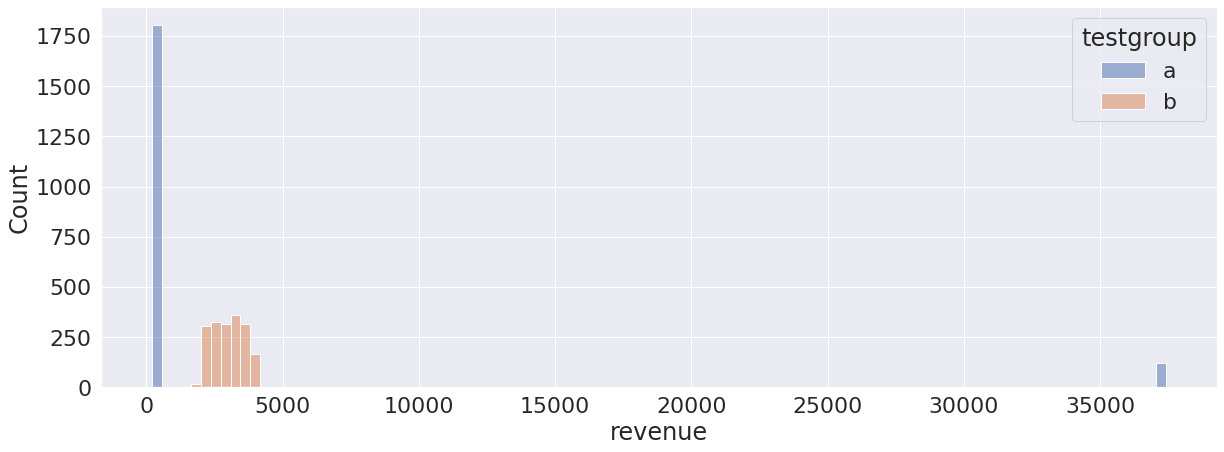

In [79]:
# Общее распределение Revenue 
sns.histplot(data=data[data['revenue'] > 0], x="revenue", hue='testgroup');

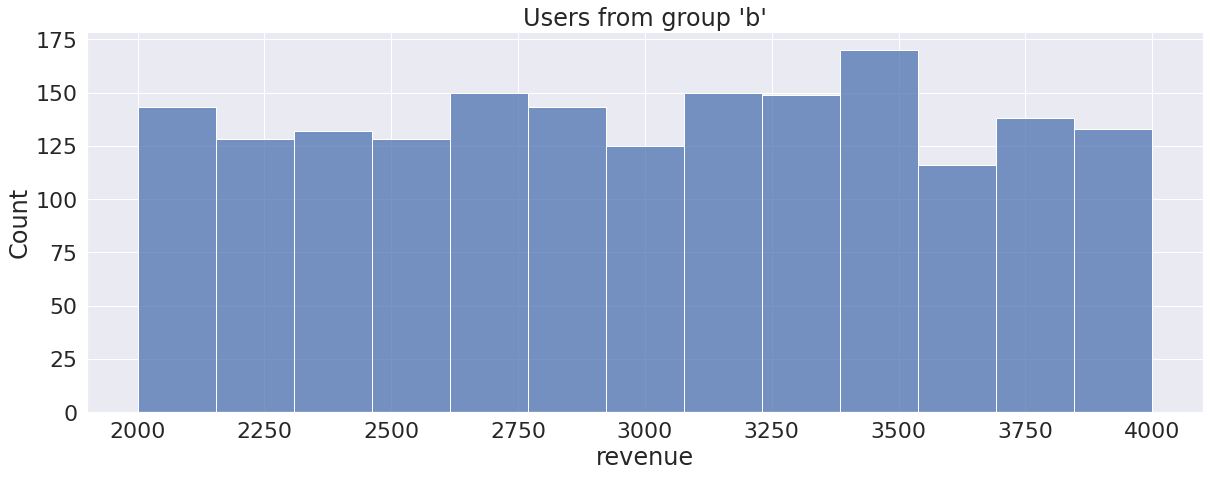

In [80]:
# Распределение Revenue в группе B
sns.histplot(data=b_paying_users, x="revenue");
plt.title("Users from group 'b'")
plt.show()

## В группе А есть две явновыраженные подгруппы пользователей:
### 1. Revenue < 500
### 2. Revenue > 37 000

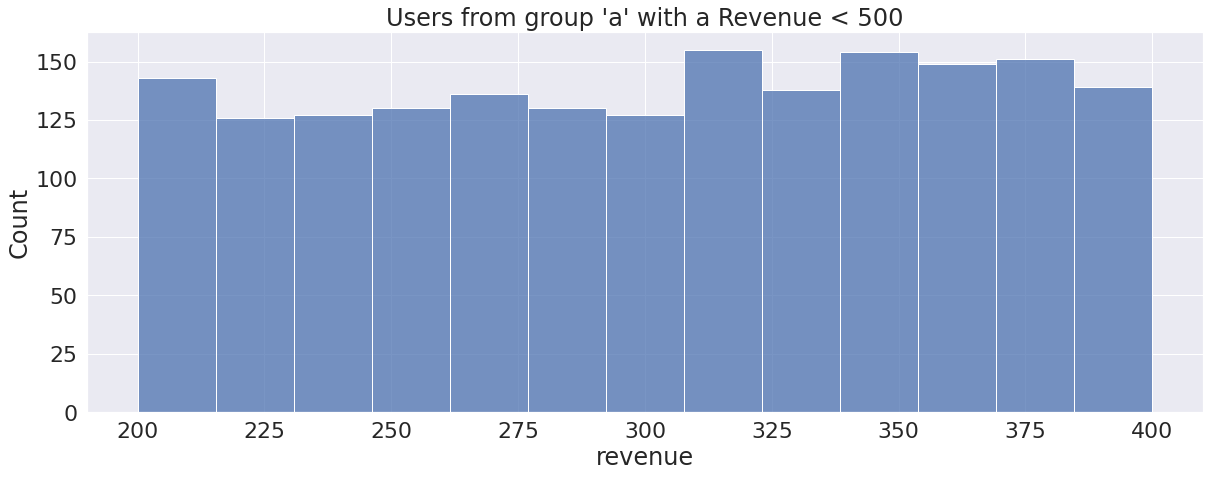

In [81]:
# Revenue < 500
sns.histplot(data=a_paying_users[a_paying_users['revenue'] < 500], x="revenue");
plt.title("Users from group 'a' with a Revenue < 500")
plt.show()

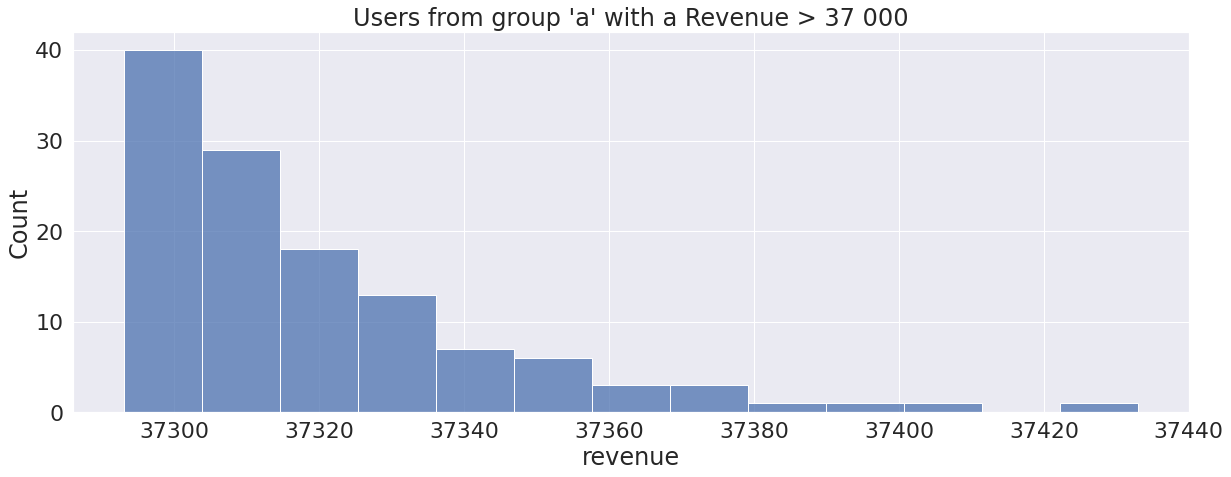

In [82]:
# Revenue > 37 000
sns.histplot(data=a_paying_users[a_paying_users['revenue'] > 37000], x="revenue");
plt.title("Users from group 'a' with a Revenue > 37 000")
plt.show()

# T-критерий будет работать плохо, так как распределение в группе "а" не является нормальным и имеет большие выбросы.
# Критерий Манна-Уитни тоже не подойдёт, так как данные из группы "а" не пересекаются с группой "b" и их ранги будут отличаться на 100%
# Лучшим решением в данном случае будет Bootstrap

## Применим Bootstrap для сравнения средних значений ARPU в группах "a" и "b"

In [83]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    

    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

# 2. ARPU
## Проверим гипотезу H1 при помощи Bootstrap метода:
### H0 - ARPU в группах "a" и "b"  не имеет статистически значимых различий
### H1 - ARPU в группах "a" и "b"  статистически значимо различаются

100%|██████████| 2000/2000 [00:44<00:00, 44.96it/s]


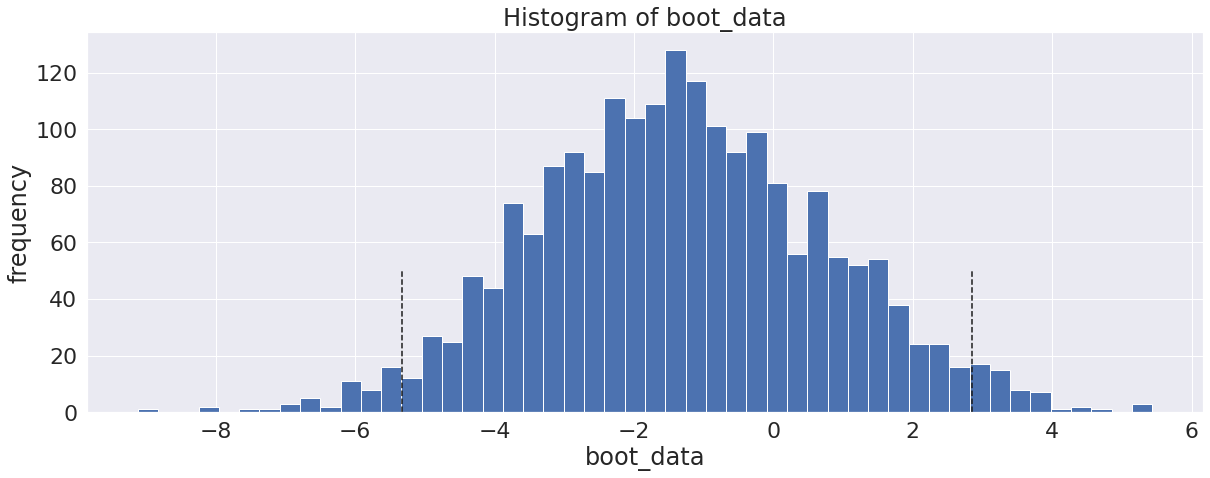

In [84]:
booted_data_arpu = get_bootstrap(a_data['revenue'], b_data['revenue'], boot_it = 2000);

In [85]:
booted_data_arpu["p_value"]

0.5166904204806737

# Так как нулевое значение попадает в наше распределение разниц двух bootstrap выборок, мы не имеем права отклонять H0, и не можем утверждать, что ARPU в группах "a" и "b" имеют статистически значимые различия

# 3. ARPPU
## Проверим гипотезу H1 при помощи Bootstrap метода:
### H0 - ARPPU в группах "a" и "b"  не имеет статистически значимых различий
### H1 - ARPPU в группах "a" и "b"  статистически значимо различаются

100%|██████████| 2000/2000 [00:00<00:00, 2634.42it/s]


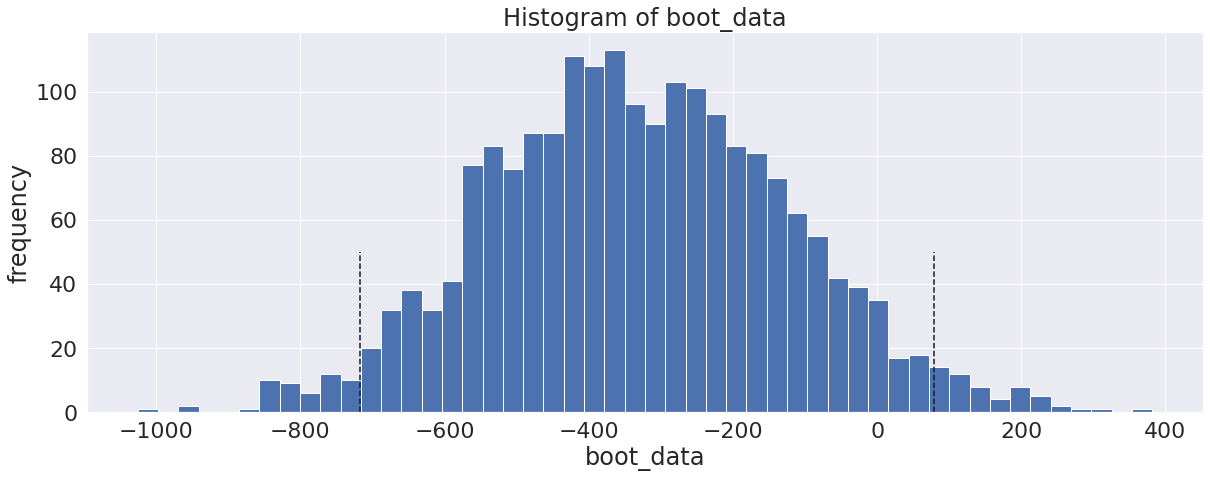

In [86]:
booted_data_arppu = get_bootstrap(a_paying_users['revenue'], b_paying_users['revenue'], boot_it = 2000);

In [87]:
booted_data_arppu["p_value"]

0.10887495067033393

# Так как нулевое значение попадает в наше распределение разниц двух bootstrap выборок, мы не имеем права отклонять H0, и не можем утверждать, что ARPPU в группах "a" и "b" имеют статистически значимые различия

# Посмотрим внимательнее на описательную статистику наших данных

In [88]:
a_data[a_data['revenue'] < 500]['revenue'].describe()

count    201980.000000
mean          2.702926
std          28.985815
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         400.000000
Name: revenue, dtype: float64

In [89]:
b_data['revenue'].describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [90]:
# Процент платящих юзеров без учёта подгруппы с revenue > 37000
a_paying_users_low = round(a_paying_users[a_paying_users['revenue'] < 500].shape[0] / a_data.shape[0] * 100, 2)
print('Процент платящих пользователей в группе А =', a_paying_users_low, '%') 

print('Процент платящих пользователей в группе B =', round(b_paying_users_count / b_data.shape[0] * 100, 2), '%')

Процент платящих пользователей в группе А = 0.89 %
Процент платящих пользователей в группе B = 0.89 %


In [91]:
# ARPU без учёта группы с revenue > 35000
print('ARPU в группе A =', round(a_data[a_data['revenue'] < 500]['revenue'].mean(), 2))
print('ARPU в группе B =', round(b_data['revenue'].mean(), 2))

ARPU в группе A = 2.7
ARPU в группе B = 26.75


In [92]:
# ARPPU без учёта группы с revenue > 35000
print('ARPPU в группе A =', round(a_paying_users[a_paying_users['revenue'] < 500]['revenue'].mean(), 2))
print('ARPPU в группе B =', round(b_paying_users['revenue'].mean(), 2))

ARPPU в группе A = 302.46
ARPPU в группе B = 3003.66


In [93]:
# Разница статистик показателя Revenue в процентах
a_paying_users_describe = a_paying_users[a_paying_users['revenue'] < 500]['revenue'].describe()
round(100 - (a_paying_users_describe / b_paying_users['revenue'].describe() * 100), 2)

count     0.00
mean     89.93
std      89.89
min      90.00
25%      89.89
50%      89.91
75%      89.88
max      90.00
Name: revenue, dtype: float64

In [94]:
a_paying_users[a_paying_users['revenue'] > 4000]['revenue'].describe()

count      123.000000
mean     37319.121951
std         25.442183
min      37293.000000
25%      37301.000000
50%      37311.000000
75%      37329.000000
max      37433.000000
Name: revenue, dtype: float64

# Описательная статистика показателя Revenue в первой подгруппе  группы А (Revenue < 500) пропорциональна группе В 
## 1. Все значения в группе А меньше примерно в 10 раз (на 90%)
## 2. Процент (и количество) платящих пользователей абсолютно такой же
# Вполне может быть, что если бы в наборе акционных предложений, действующих для группы А не было возможности тратить свыше 37000, то конверсия была бы такой же как и в группе В, но метрики ARPU и  ARPPU отличались бы в 10 раз. Но имеющихся данных не достаточно, чтобы это утверждать.

# Выводы:
## Не стоит принимать итоговое решение, основываясь исключительно на этих данных, так как, очевидно, что наборы акционных предложений в группах "a" и "b" принципиально отличаются. Возможно, расходы на реализацию варианта "а" нивелируют его наиболее высокую конверсию, или в долгосрочной перспективе вариант "b" является наиболее выгодным. Возможно у компании будет репутационный ущерб связанный с реализаций акционных предложений группы "а" и т.д.                           Но, основываясь только на предоставленных данных, можно сделать следующие выводы:
## 1. Если наборы акционных предложений являются взаимоисключающими, то лучше выбрать набор "a", так как показатели ARPU и ARPPU статистически значимо не различаются, но конверсия в группе "а" больше чем в группе "b"
## 2. Если у нас есть возможность объеденить две группы акционных предложений, то: Лучший набор предложений должен выглядить как комбинация всех предложений для группы В и предложений для группы А, образующих подгруппу с Revenue > 37 000
### Таким образом у нас будет две группы пользователй c Revenue > 0:
####     1. Средний Revenue == 3003, Стандартное отклонение == 572
####    2. Средний Revenue == 37319, Стандартное отклонение == 25